<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/05-Time_Series/C-ERCOT_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing electricity usage from Electric Reliability Council of Texas (ERCOT)

ERCOT releases the electricity usage of their grid at http://www.ercot.com/gridinfo/load

The archives are at: http://www.ercot.com/gridinfo/load/load_hist

ERCOT also publishes their own load forecasts, this is a good baseline for any model.

In [1]:
#@title Setup

!pip install -U -q PyMySQL sqlalchemy
# prophet

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import text

import numpy as np

import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.2 MB/s eta 0:00:00


In [2]:
#@title Plotting Setup

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 8x3 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 2  # Default marker size of 2 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points

# Load and plot the data


In [3]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'ercot',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

# This query loads the dataset from the DB into the dataframe
with engine.connect() as con:
  sql = "SELECT * FROM ercot.electricity WHERE DATE_TIME < '2023-06-01'"
  df = pd.read_sql(text(sql), con=con)
  df = df.set_index('DATE_TIME')

In [4]:
df

COAST         EAST        FWEST        NORTH  \
DATE_TIME                                                                  
2002-01-01 01:00:00   8331.469266  1111.096549  1094.045496   995.298392   
2002-01-01 02:00:00   8107.805431  1091.481584  1083.517981   981.195477   
2002-01-01 03:00:00   7890.721717  1080.257616  1085.038740   971.305257   
2002-01-01 04:00:00   7799.817527  1079.726403  1093.381853   971.262963   
2002-01-01 05:00:00   7815.968171  1087.934961  1106.651296   982.535591   
...                           ...          ...          ...          ...   
2023-05-31 19:00:00  17540.145681  2290.135201  5840.153465  1489.972357   
2023-05-31 20:00:00  16830.963445  2173.074464  5757.713701  1430.314138   
2023-05-31 21:00:00  16249.277372  2061.613777  5712.504436  1357.031324   
2023-05-31 22:00:00  15690.099605  1953.621682  5696.530667  1305.911891   
2023-05-31 23:00:00  14800.724443  1802.798146  5605.837507  1224.213988   

                            NCENT        SOUTH         SCENT         WEST  \
DATE_TIME                                                                   
2002-01-01 01:00:00  10336.304899  2165.007571   4793.193560   843.747177   
2002-01-01 02:00:00  10178.052738  2092.374118   4766.918187   835.488188   
2002-01-01 03:00:00  10100.887710  2042.080714   4702.918892   830.694878   
2002-01-01 04:00:00  10081.565109  2011.935791   4669.064391   835.068413   
2002-01-01 05:00:00  10192.218670  2002.487678   4695.011904   848.598209   
...                           ...          ...           ...          ...   
2023-05-31 19:00:00  19870.685584  5421.849554  11196.320391  1547.890882   
2023-05-31 20:00:00  18926.254677  5160.743439  10820.919849  1471.589427   
2023-05-31 21:00:00  18042.293868  4963.232330  10363.331700  1412.062420   
2023-05-31 22:00:00  17295.147115  4810.546445   9939.491289  1384.384586   
2023-05-31 23:00:00  16001.147539  4521.148141   9248.031281  1305.815735   

                            ERCOT  
DATE_TIME                          
2002-01-01 01:00:00  29670.162911  
2002-01-01 02:00:00  29136.833703  
2002-01-01 03:00:00  28703.905525  
2002-01-01 04:00:00  28541.822450  
2002-01-01 05:00:00  28731.406478  
...                           ...  
2023-05-31 19:00:00  65197.153116  
2023-05-31 20:00:00  62571.573139  
2023-05-31 21:00:00  60161.347225  
2023-05-31 22:00:00  58075.733278  
2023-05-31 23:00:00  54509.716780  

[187702 rows x 9 columns]

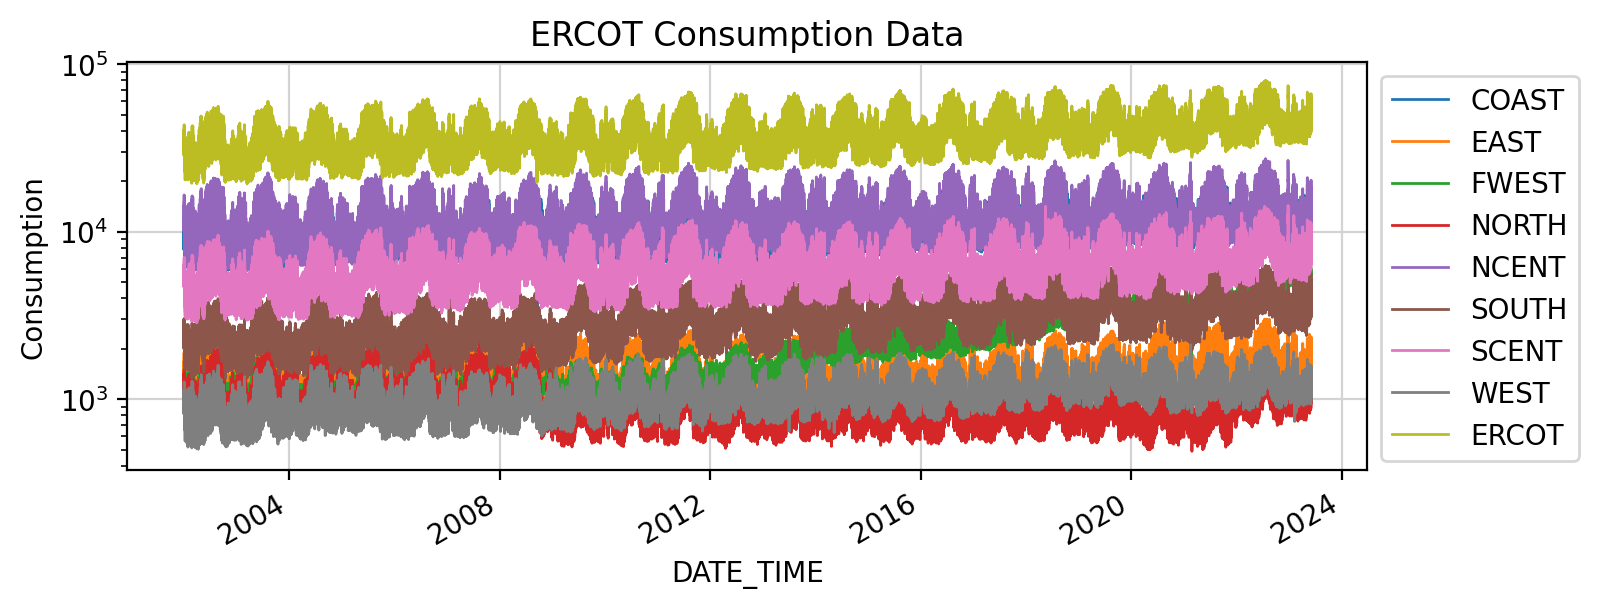

In [5]:
df.plot(
    logy=True,
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # move the legend out of the chart

<Axes: title={'center': 'ERCOT Consumption Data'}, xlabel='DATE_TIME', ylabel='Consumption'>

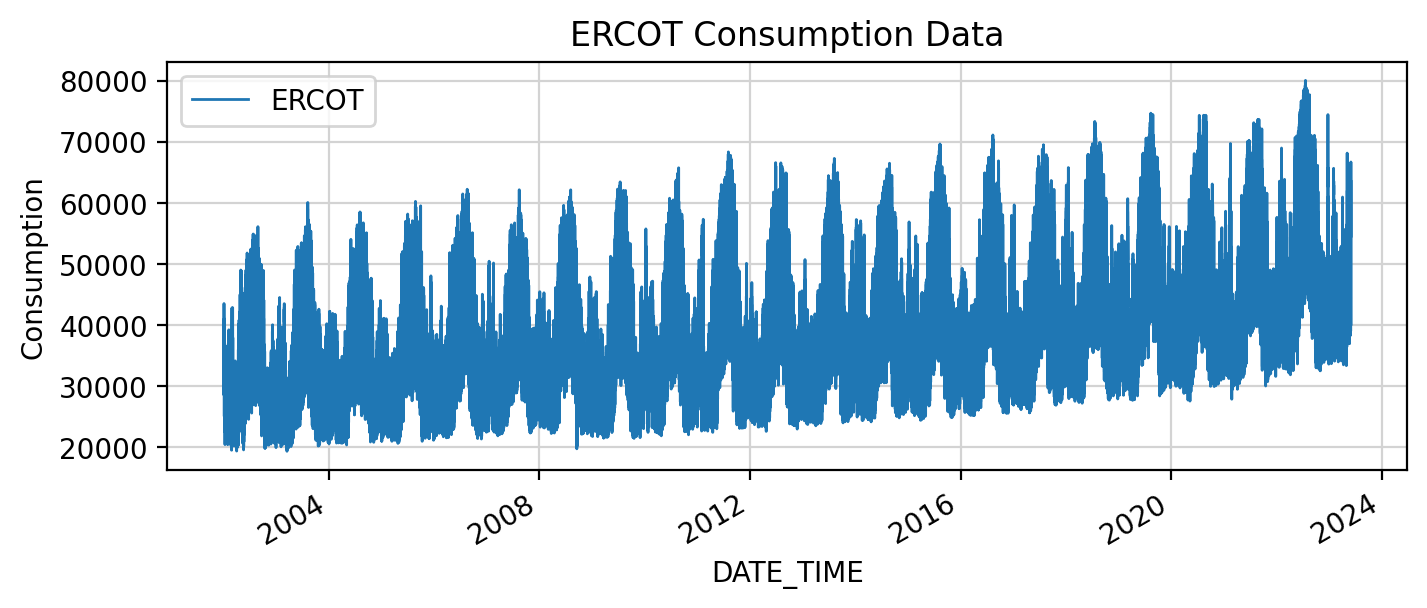

In [6]:
df.plot(
    y = 'ERCOT',
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)

## Analyzing the time series using Prophet

For full and current documentation [please check the webpage of the project](https://facebook.github.io/prophet/).

In [7]:
# We can remove the resampling part and use hourly data
# but it takes ~10 mins on Colab to process the time series
# with hourly data. The tradeoff of working with daily data
# is that we do not extract the seasonality component within
# the day.

edf = (
    df
    .resample('1D').sum() # we will work with daily data
    .reset_index() # make the datetime index a regular column
    .filter( items = ['DATE_TIME', 'ERCOT']) # keep only datetime and ERCOT
    .rename( # prophet requires specific names for time ("ds") and for the time series ("y")
        {
          'DATE_TIME': 'ds',
          'ERCOT': 'y'
        },
        axis="columns" )
)


# This dataframe is ready for Prophet
edf


ds             y
0    2002-01-01  7.290946e+05
1    2002-01-02  8.586851e+05
2    2002-01-03  8.870387e+05
3    2002-01-04  8.358059e+05
4    2002-01-05  6.881782e+05
...         ...           ...
7816 2023-05-27  1.170941e+06
7817 2023-05-28  1.144203e+06
7818 2023-05-29  1.181203e+06
7819 2023-05-30  1.234965e+06
7820 2023-05-31  1.277294e+06

[7821 rows x 2 columns]

<Axes: xlabel='ds'>

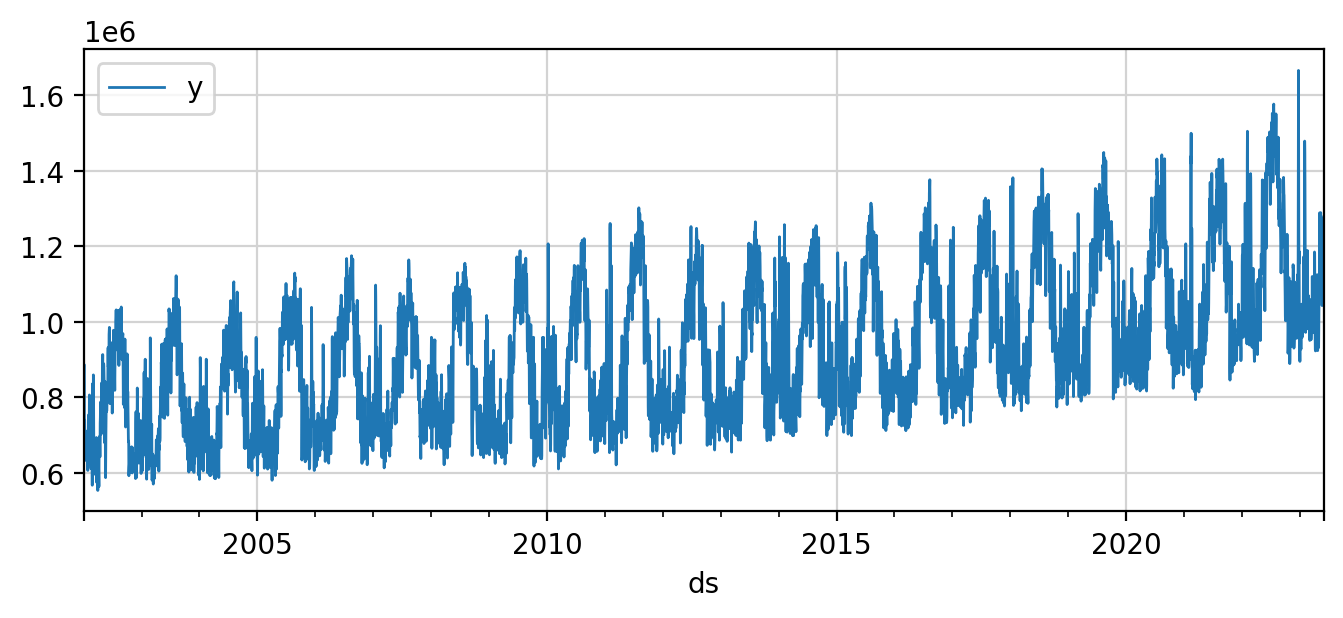

In [8]:
# Plot the daily usage:
edf.plot(y='y', x='ds')

In [9]:
m = Prophet(seasonality_mode='multiplicative')

# We ask to also add the US holidays as regressors
m.add_country_holidays(country_name='US')

# Take as input the time series and extract the components
m.fit(edf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/zazahaig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/2cz5yo32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59196', 'data', 'file=/tmp/tmpsqahyi9o/zazahaig.json', 'init=/tmp/tmpsqahyi9o/2cz5yo32.json', 'output', 'file=/tmp/tmpsqahyi9o/prophet_modelcbjo8_5a/prophet_model-20250617034020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
# Setup for hourly forecasts, one year in the future
# future = m.make_future_dataframe(periods=365 * 24, freq='H')

# Setup for daily forecasts, one year in the future
future = m.make_future_dataframe(periods=365)
future.tail()

ds
8181 2024-05-26
8182 2024-05-27
8183 2024-05-28
8184 2024-05-29
8185 2024-05-30

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat    yhat_lower    yhat_upper
8181 2024-05-26  1.215410e+06  1.119210e+06  1.315665e+06
8182 2024-05-27  1.229488e+06  1.129854e+06  1.338169e+06
8183 2024-05-28  1.313513e+06  1.212915e+06  1.413236e+06
8184 2024-05-29  1.326406e+06  1.222555e+06  1.429060e+06
8185 2024-05-30  1.337717e+06  1.239692e+06  1.441783e+06

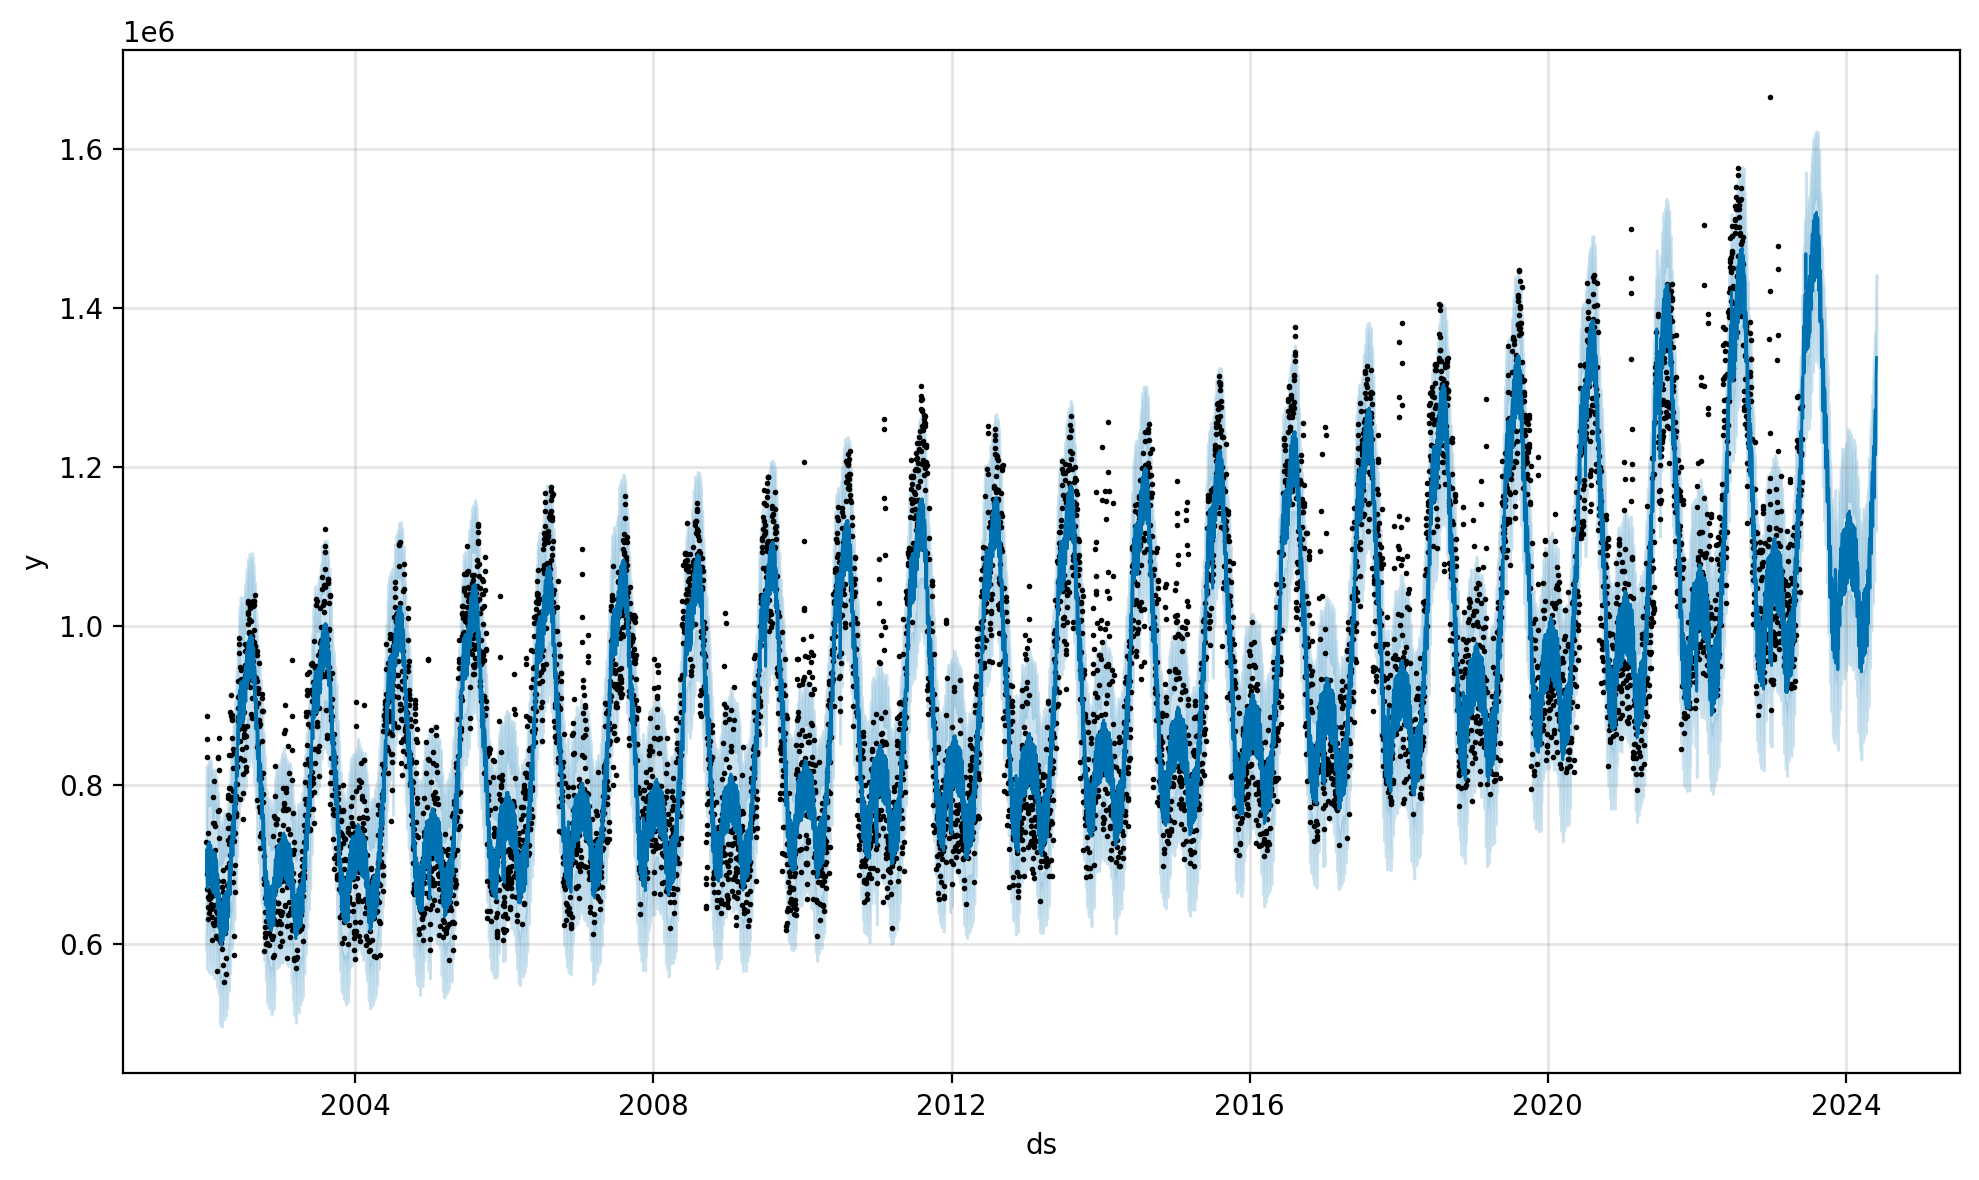

In [12]:
fig1 = m.plot(forecast)

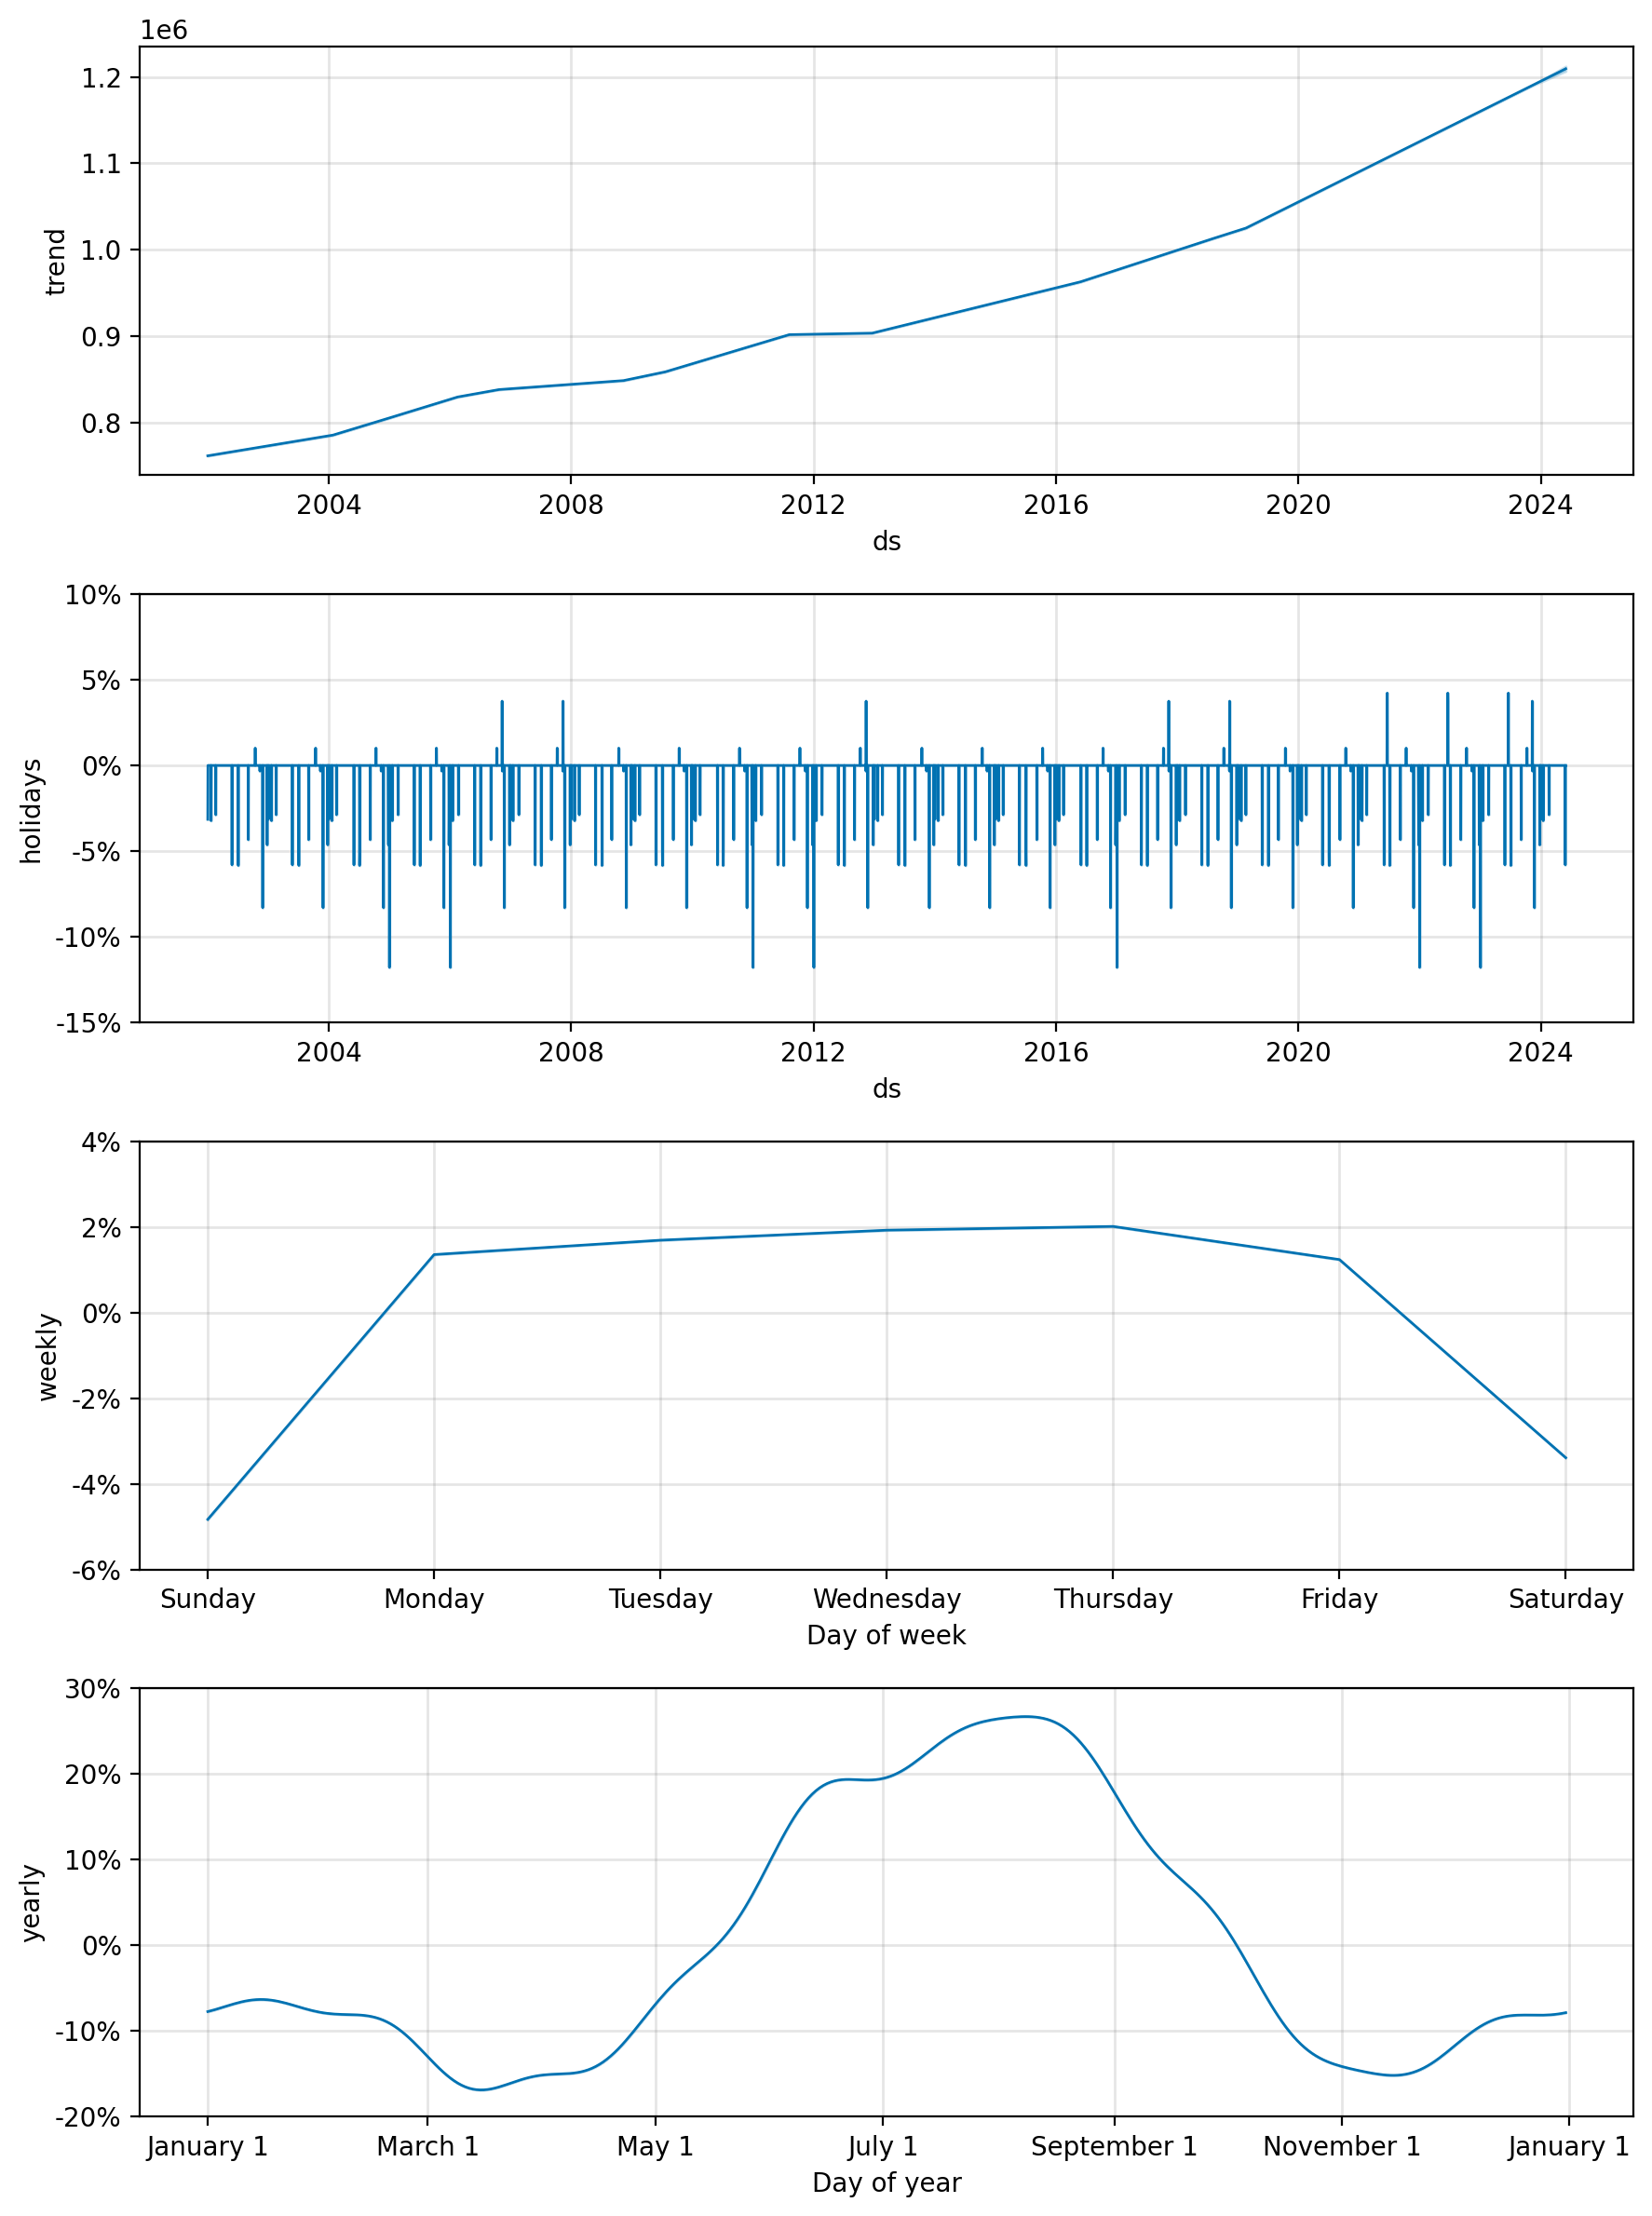

In [13]:
fig2 = m.plot_components(forecast)

In [14]:
plot_plotly(m, forecast)

In [15]:
plot_components_plotly(m, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



## Performance Evaluation

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

### Training, validation, forecast

* **Training**: Data in the *initial* or *estimation* or *training* period are used to help select the model and to estimate its parameters. Forecasts made in this period are not really "honest" because data on both sides of each observation are used to help determine the forecast.

* **Validation**: Data in the *validation* or *horizon* period are not given to the algorithm while creating the model and are *held out* during model training. Instead, we use the data in this period to evaluate the quality of the forecasting. Often the results of the evaluation are called ***backtests***.

* **Forecast**: This is the time period for which we make our actual forecasts. Please note that even if we do have data for the forecasting period, these should not be used to guide the selection of our algorithm or other settings of our algorithm.

<img src="https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_4_0.png">

In [16]:
# Method 1: Cross-validation with moving cutoffs
df_cv = cross_validation(m,
      initial='730 days', # We will take the first two years of the data
      horizon = '365 days', # and we will make predictions for one year
      period='180 days', # then we will move the cutoff 180 days forward and continue
                         # until we reach the end of the time series
                         # (for our series with 21 years of data, minus two
                         # years for starting the training, this results
                         # in 38 different cutoff dates used for evaluation)
      parallel="processes" # speedup using parallelism
      )


INFO:prophet:Making 38 forecasts with cutoffs between 2004-03-06 00:00:00 and 2022-05-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ef1da0005d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/hujxw8mx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/qegs1epg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/39xefltj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/deci2ola.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/a9mixxxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/wuirgjoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/kzuqdf6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/937xykav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/1qqz_gt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50885', 'data', 'file=

In [17]:
df_cv # This shows our predictions (y_hat) against the actual value (y)
      # and also shows lower and upper estimates for y_hat.

ds          yhat    yhat_lower    yhat_upper             y  \
0     2004-03-07  6.204721e+05  5.501202e+05  6.862985e+05  5.922129e+05   
1     2004-03-08  6.772755e+05  6.053585e+05  7.476673e+05  6.455420e+05   
2     2004-03-09  6.776568e+05  6.093529e+05  7.536914e+05  6.460384e+05   
3     2004-03-10  6.795741e+05  6.052740e+05  7.499800e+05  6.479747e+05   
4     2004-03-11  6.756412e+05  6.059280e+05  7.496724e+05  6.431605e+05   
...          ...           ...           ...           ...           ...   
13865 2023-05-27  1.171709e+06  1.066055e+06  1.263902e+06  1.170941e+06   
13866 2023-05-28  1.164310e+06  1.064825e+06  1.252878e+06  1.144203e+06   
13867 2023-05-29  1.181281e+06  1.077623e+06  1.277770e+06  1.181203e+06   
13868 2023-05-30  1.260201e+06  1.165287e+06  1.358479e+06  1.234965e+06   
13869 2023-05-31  1.272158e+06  1.168507e+06  1.364515e+06  1.277294e+06   

          cutoff  
0     2004-03-06  
1     2004-03-06  
2     2004-03-06  
3     2004-03-06  
4     2004-03-06  
...          ...  
13865 2022-05-31  
13866 2022-05-31  
13867 2022-05-31  
13868 2022-05-31  
13869 2022-05-31  

[13870 rows x 6 columns]

In [18]:
# Method 2: We explicitly specify the cutoffs

cutoffs = pd.to_datetime(['2019-01-01', '2020-01-01', '2021-01-01'])

# Use the three cutoffs above and make predictions for 365 days after the cutoff
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
df_cv2

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/a8ki0ugg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/qyx2r1ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12691', 'data', 'file=/tmp/tmpsqahyi9o/a8ki0ugg.json', 'init=/tmp/tmpsqahyi9o/qyx2r1ai.json', 'output', 'file=/tmp/tmpsqahyi9o/prophet_modell7bry8_9/prophet_model-20250617034032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/f_rhvfa3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqahyi9o/tpp0gxnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

ds          yhat     yhat_lower    yhat_upper             y  \
0    2019-01-02  9.839923e+05  890153.529289  1.071795e+06  1.132863e+06   
1    2019-01-03  9.857198e+05  889793.655618  1.079612e+06  1.100968e+06   
2    2019-01-04  9.779373e+05  886862.837479  1.079356e+06  1.019282e+06   
3    2019-01-05  9.288872e+05  829833.394863  1.022794e+06  9.079363e+05   
4    2019-01-06  9.150497e+05  822062.982291  1.013796e+06  8.404972e+05   
...         ...           ...            ...           ...           ...   
1090 2021-12-28  1.026339e+06  927810.343453  1.119758e+06  9.760974e+05   
1091 2021-12-29  1.030465e+06  932435.369953  1.119609e+06  9.749000e+05   
1092 2021-12-30  1.031586e+06  930448.137261  1.134745e+06  9.615776e+05   
1093 2021-12-31  8.662138e+05  767201.925165  9.734074e+05  9.677606e+05   
1094 2022-01-01  9.398851e+05  842615.819477  1.043196e+06  9.722954e+05   

         cutoff  
0    2019-01-01  
1    2019-01-01  
2    2019-01-01  
3    2019-01-01  
4    2019-01-01  
...         ...  
1090 2021-01-01  
1091 2021-01-01  
1092 2021-01-01  
1093 2021-01-01  
1094 2021-01-01  

[1095 rows x 6 columns]

### Evaluation metrics

There are many metrics that can be used to evaluate the quality of the forecasts

* **MSE (Mean Squared Error)**: Measures the average squared difference between the predicted and actual values in a time series.
* **RMSE (Root Mean Squared Error)**: The square root of the MSE, providing a measure of the average magnitude of the prediction errors.
* **MAE (Mean Absolute Error)**: Calculates the average absolute difference between the predicted and actual values, ignoring the direction of errors.
* **MAPE (Mean Absolute Percentage Error)**: Computes the average percentage difference between the predicted and actual values, relative to the actual values.
* **MDAPE (Median Absolute Percentage Error)**: Similar to MAPE, but uses the median instead of the mean, making it more robust to outliers.
* **SMAPE (Symmetric Mean Absolute Percentage Error)**: A symmetric variant of MAPE that avoids division by zero and handles overestimations and underestimations equally.
* **COVERAGE**: Represents the proportion of observed values that fall within a certain prediction interval or confidence interval, indicating the reliability of the forecasts.


The popularity and usage of specific metrics for time series evaluation can vary depending on the context and the specific requirements of the problem at hand. However, some commonly used metrics are:

* MSE (Mean Squared Error): It is a widely used metric for measuring the overall accuracy of predictions and is often used in regression tasks.
* RMSE (Root Mean Squared Error): RMSE is frequently used as it provides an easily interpretable measure of the average prediction error in the same units as the target variable.
* MAE (Mean Absolute Error): MAE is popular due to its simplicity and ease of interpretation, as it gives an average of the absolute differences between predicted and actual values.
* MAPE (Mean Absolute Percentage Error): MAPE is commonly used when it is important to understand the percentage error in predictions relative to the actual values.
* SMAPE (Symmetric Mean Absolute Percentage Error): SMAPE is utilized when it is necessary to account for both overestimations and underestimations in the predictions.

### Manual calculation of performance metrics

In [19]:
df_cv

ds          yhat    yhat_lower    yhat_upper             y  \
0     2004-03-07  6.204721e+05  5.501202e+05  6.862985e+05  5.922129e+05   
1     2004-03-08  6.772755e+05  6.053585e+05  7.476673e+05  6.455420e+05   
2     2004-03-09  6.776568e+05  6.093529e+05  7.536914e+05  6.460384e+05   
3     2004-03-10  6.795741e+05  6.052740e+05  7.499800e+05  6.479747e+05   
4     2004-03-11  6.756412e+05  6.059280e+05  7.496724e+05  6.431605e+05   
...          ...           ...           ...           ...           ...   
13865 2023-05-27  1.171709e+06  1.066055e+06  1.263902e+06  1.170941e+06   
13866 2023-05-28  1.164310e+06  1.064825e+06  1.252878e+06  1.144203e+06   
13867 2023-05-29  1.181281e+06  1.077623e+06  1.277770e+06  1.181203e+06   
13868 2023-05-30  1.260201e+06  1.165287e+06  1.358479e+06  1.234965e+06   
13869 2023-05-31  1.272158e+06  1.168507e+06  1.364515e+06  1.277294e+06   

          cutoff  
0     2004-03-06  
1     2004-03-06  
2     2004-03-06  
3     2004-03-06  
4     2004-03-06  
...          ...  
13865 2022-05-31  
13866 2022-05-31  
13867 2022-05-31  
13868 2022-05-31  
13869 2022-05-31  

[13870 rows x 6 columns]

In [20]:
# Calculate MAPE which is defined a "MAPE = abs(actual - prediction) / abs(prediction)"
df_cv['mape'] = np.abs(df_cv['y'] - df_cv['yhat']) / np.abs(df_cv['y'])

In [21]:
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']

<Axes: xlabel='horizon'>

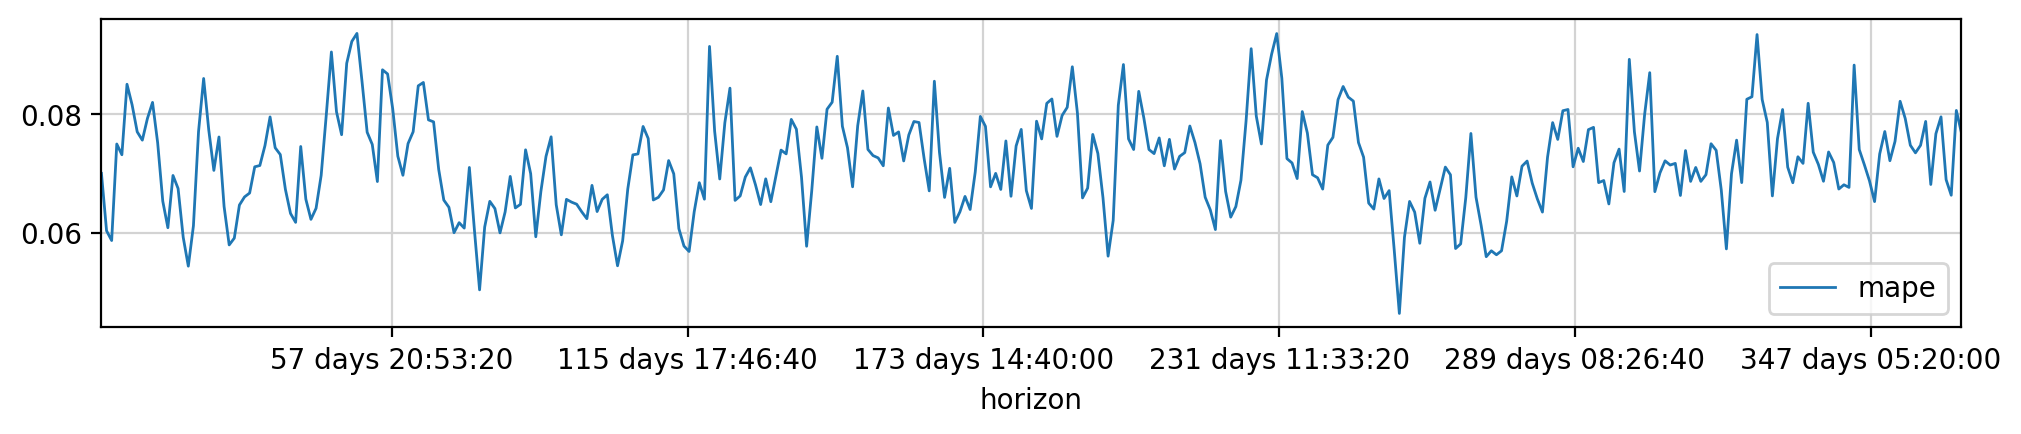

In [22]:
df_cv.pivot_table(
    index = 'horizon',
    values = 'mape',
    aggfunc = 'mean'
).plot(
    figsize = (12,2)
)

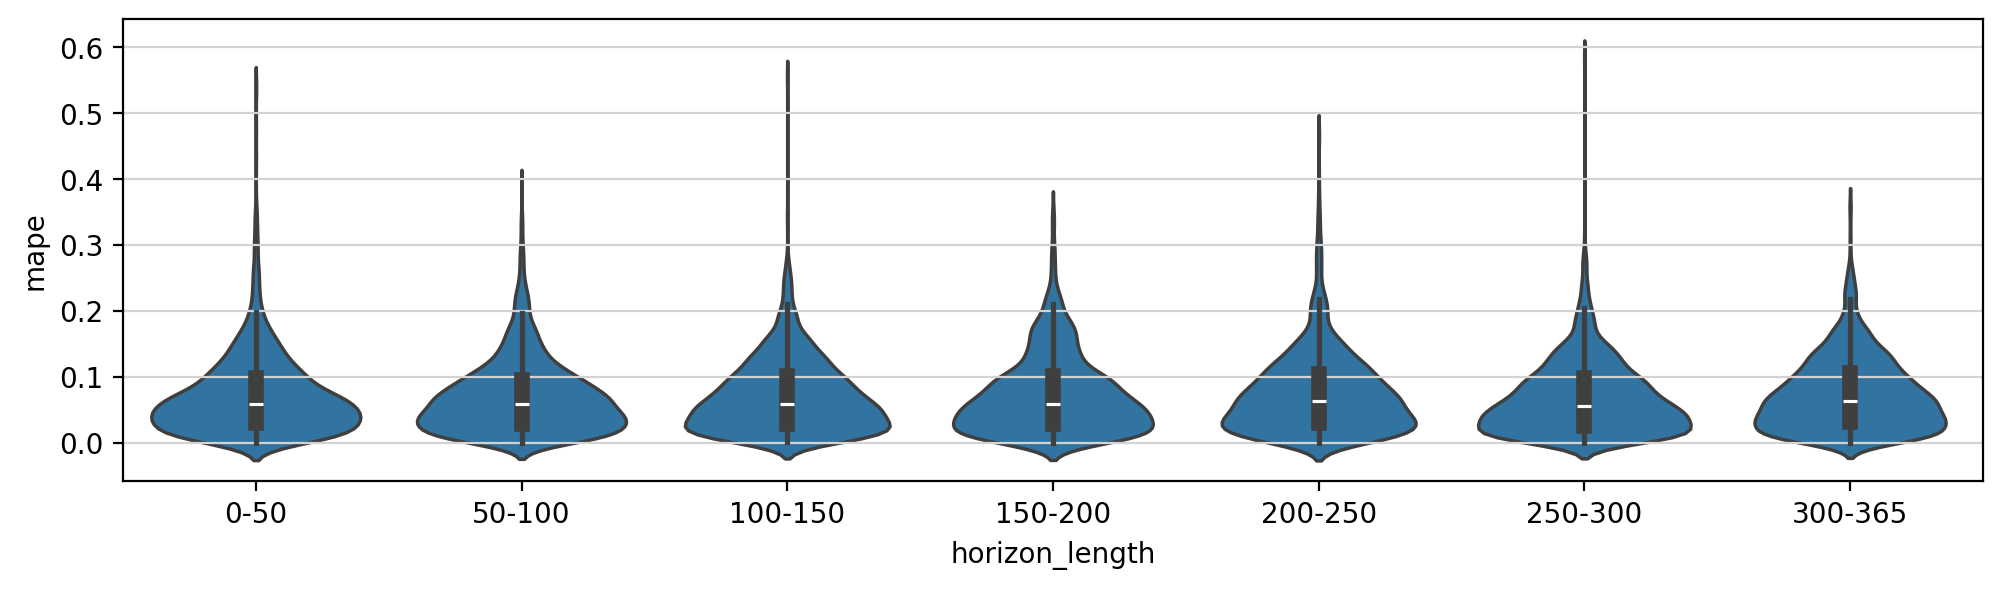

In [23]:
# Now, let's visualize the MAPE metric as a function of the horizon length
# using a violin plot, to understand not only the mean but also the distribution


# Create categories/bins for grouping the x-axis values
# Grouping into 7 bins
bins = [0, 50, 100, 150, 200, 250, 300, 365]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-365']
# Convert horizon to a number (instead of a "x days")
df_cv['horizon_length'] = df_cv['horizon'].dt.total_seconds() / (24 * 60 * 60)
# and group the numbers into predefined ranges
df_cv['horizon_length'] = pd.cut(df_cv['horizon_length'], bins=bins, labels=labels)

plt.figure(figsize=(12, 3))
ax = sns.violinplot(
    data = df_cv,
    x = 'horizon_length',
    y = 'mape',
)

### Automatic calculation of performance metrics

Now let's see how we can calculate these metrics using the Prophet package

The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [24]:
df_p = performance_metrics(df_cv)

In [25]:
df_p

horizon           mse          rmse           mae      mape     mdape  \
0    37 days  8.219518e+09  90661.558721  68328.179346  0.070506  0.057105   
1    38 days  8.226103e+09  90697.865209  68262.123463  0.070454  0.057162   
2    39 days  8.239003e+09  90768.955297  68282.598800  0.070515  0.057624   
3    40 days  8.236773e+09  90756.668176  68446.588757  0.070727  0.057511   
4    41 days  8.104661e+09  90025.888760  68136.245151  0.070497  0.057162   
..       ...           ...           ...           ...       ...       ...   
324 361 days  8.769338e+09  93644.741728  72604.133928  0.074316  0.062830   
325 362 days  8.669315e+09  93109.155702  72177.164735  0.073794  0.062603   
326 363 days  8.572671e+09  92588.717018  71815.688959  0.073404  0.061143   
327 364 days  8.687474e+09  93206.618785  72166.176513  0.073630  0.062603   
328 365 days  8.820641e+09  93918.265681  72494.148414  0.073789  0.062149   

        smape  coverage  
0    0.070570  0.722062  
1    0.070492  0.721341  
2    0.070519  0.720981  
3    0.070681  0.718818  
4    0.070383  0.718818  
..        ...       ...  
324  0.074938  0.671233  
325  0.074365  0.671954  
326  0.073934  0.672675  
327  0.074203  0.673396  
328  0.074423  0.671593  

[329 rows x 8 columns]

<Axes: xlabel='horizon'>

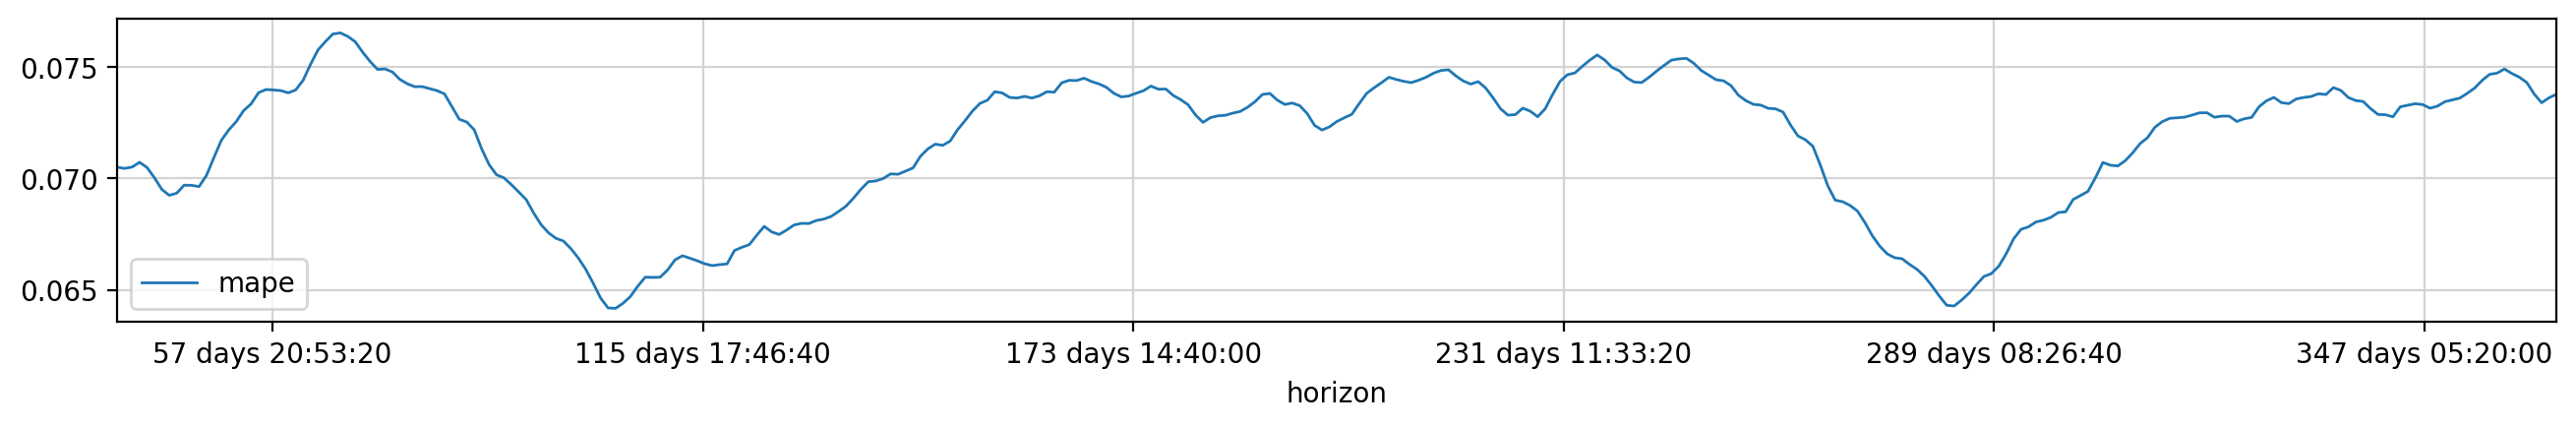

In [26]:
df_p.plot(
    x = 'horizon',
    y = 'mape',
    figsize = (16,2)
)

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



(0.0, 0.2)

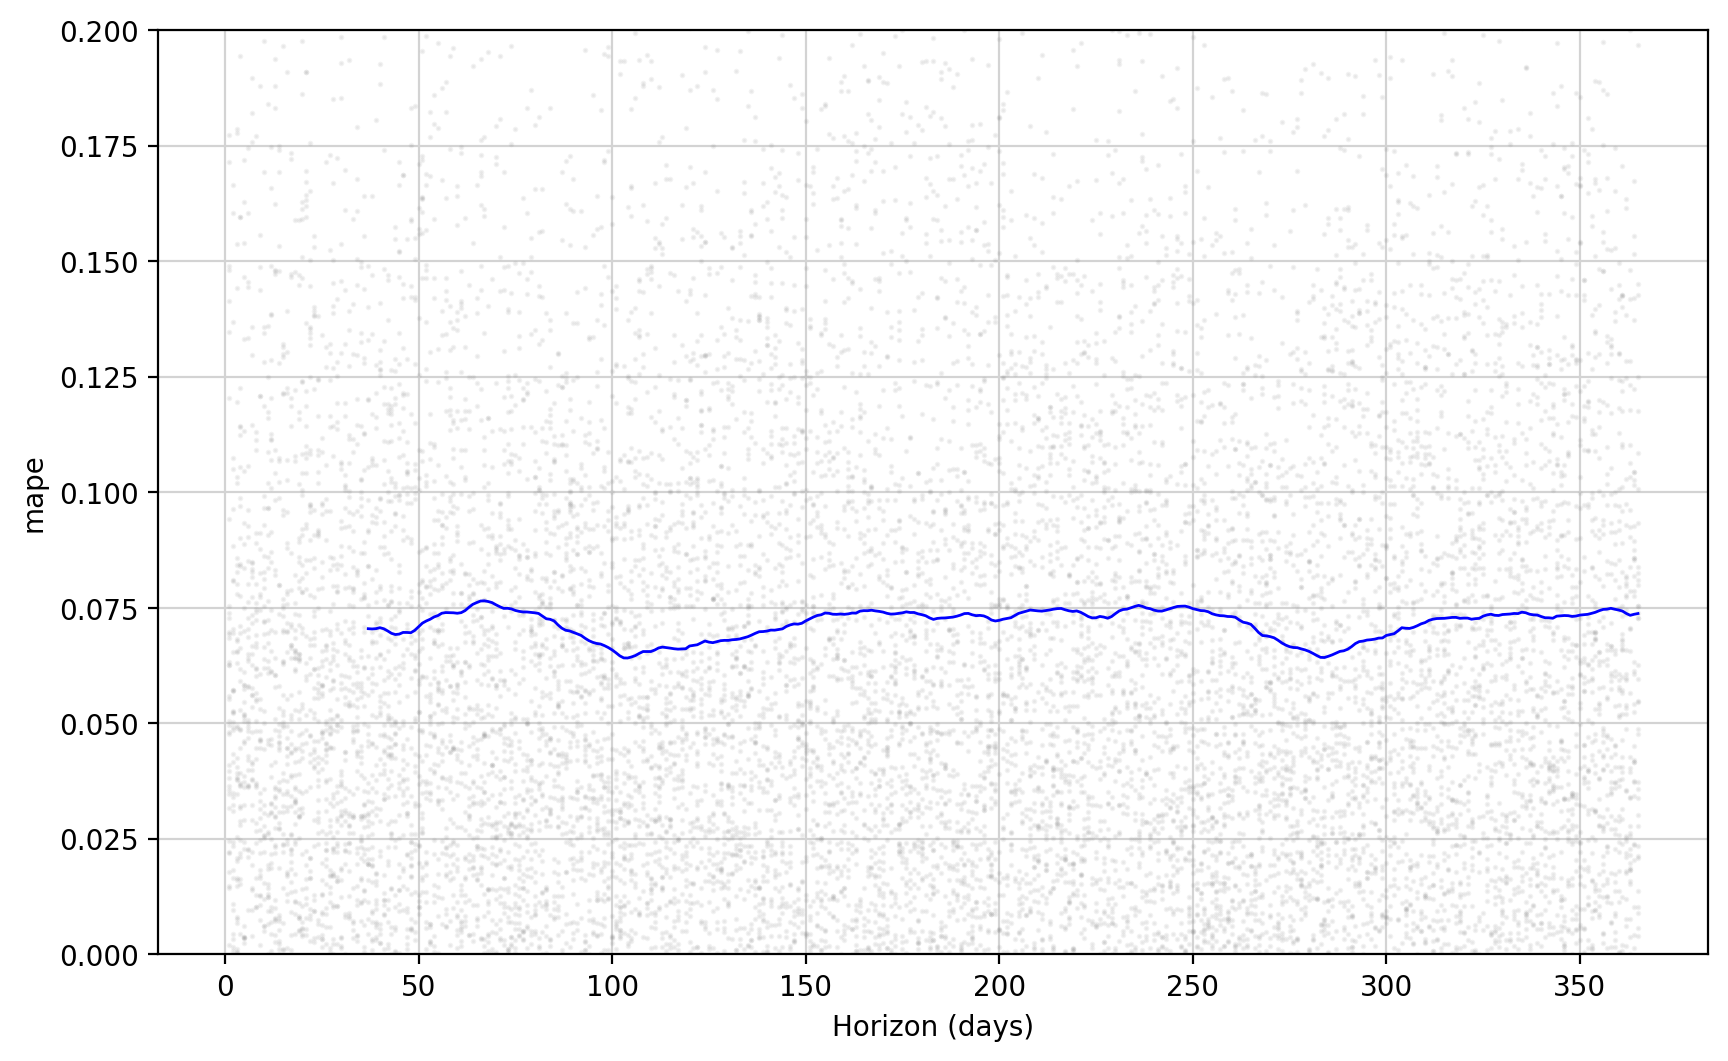

In [27]:
# A Prophet-provided visualization that shows the average value of the metric
# (blue line) against the various measurements in different points in time

fig = plot_cross_validation_metric(df_cv, metric='mape')
# Get the Axes object from the Figure
ax = fig.get_axes()[0]
ax.set_ylim(0, 0.2)